<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/Elevation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author**: **Tewabe** **Melkamu**

Date: 3/10/2025

Elevation_and reference Data Collection


In [2]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-mftewabe')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data** **spacification** **and** **visualization**  

In [3]:
# 1. Define the study region (Ethiopia)
# -------------------------------------------------------------------
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load and clip the SRTM DEM
# -------------------------------------------------------------------
srtm = ee.Image("CGIAR/SRTM90_V4").clip(taiwan)

# -------------------------------------------------------------------
# 3. Create a mask for water bodies
# -------------------------------------------------------------------
# Load ESA WorldCover and clip to Ethiopia.
#worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)

# Class definitions from ESA WorldCover:
# 50 = Built-up
# 80 = Permanent water bodies
# We keep only pixels that are NOT 80.
#ask = worldcover.neq(50).And(worldcover.neq(80))

# Apply this mask to the SRTM DEM
#dem_masked = srtm.updateMask(mask)

# -------------------------------------------------------------------
# 5. Visualize the data interactively
# -------------------------------------------------------------------
Map = geemap.Map(center=[23.5, 121], zoom=7)

# Original SRTM
Map.addLayer(
    srtm,
    {"min": 0, "max": 3000, "palette": ['white', 'blue', 'green', 'yellow', 'orange', 'red']},
    "Original SRTM DEM"
)

# WorldCover (for reference)
#Map.addLayer(
   # worldcover,
   # {},
   # "WorldCover (original)"
#)

# Masked DEM (no upscaling)
Map.addLayer(
    srtm,
    {"min": 0, "max": 3000, "palette": ['white', 'blue', 'green', 'yellow', 'orange', 'red']},
    "Masked SRTM DEM (Built-up & Water)"
)

# Ethiopia boundary
Map.addLayer(taiwan, {}, "Taiwan Boundary")
Map.addLayerControl()
#Map
# -------------------------------------------------------------------
# 5. Export the masked dem image to Google Drive
# -------------------------------------------------------------------
task = ee.batch.Export.image.toDrive(
    image=srtm,
    description='DEM',
    folder='DEM',  # Update this to your desired Drive folder.
    fileNamePrefix='DEM',
    region=taiwan.geometry().bounds().getInfo()['coordinates'],
    scale=1000,  # MODIS resolution is ~1km.
    crs='EPSG:32651',
    maxPixels=1e13
)
task.start()

print("Export task started.")

Export task started.


**Explor** **in** **Python**

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.5 MB/s eta 0:00:00


# Non_zero dem

In [ ]:
# Import necessary libraries
import rasterio
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Define the file path to your DEM file on Google Drive
# Update this path to match where your DEM is stored
dem_path = "/content/drive/MyDrive/DEM/ELVref2.tif"

# prompt: remove 0 elevation and  save the dem-

# Read the DEM data using rasterio and keep the dataset open
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  # Read the first band as a NumPy array
    # Get the profile while the dataset is still open
    profile = src.profile

# Assuming 'dem_data' is your NumPy array from the previous code
dem_data_no_zero = np.where(dem_data == 0, np.nan, dem_data)

# Update metadata for the output raster
profile.update(dtype=rasterio.float32, nodata=np.nan) # Update dtype and nodata

# Define the output path for the new DEM file
output_path = "/content/drive/MyDrive/DEM/ELVref23.tif"

# Write the modified DEM to a new GeoTIFF file
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(dem_data_no_zero.astype(rasterio.float32), 1)

print(f"DEM with zeros removed saved to: {output_path}")

# Optional: Display the modified DEM
plt.figure(figsize=(10, 8))
plt.imshow(dem_data_no_zero, cmap="terrain")
plt.title("DEM from Google Drive (Zeros Removed)")
plt.xlabel("Column")
plt.ylabel("Row")
plt.colorbar(label="Elevation")
plt.show()

In [ ]:
!pip install rasterio numpy


# mean ELV

In [32]:
import rasterio
import numpy as np

def save_mean_image(input_path, output_path,
                    background_value=None,
                    valid_min=None,
                    valid_max=None):
    """
    Reads a single-band GeoTIFF, replaces nodata and/or background values
    with NaN, computes the overall mean of valid pixels, and saves a new
    GeoTIFF where valid pixels are set to that mean and invalid (background/nodata)
    remain NaN.

    Parameters:
    -----------
    input_path : str
        Path to the input GeoTIFF file.
    output_path : str
        Path to the output GeoTIFF file.
    background_value : float or int, optional
        A known pixel value used as background that should be treated as invalid.
    valid_min : float, optional
        Minimum valid pixel value (everything below is set to NaN).
    valid_max : float, optional
        Maximum valid pixel value (everything above is set to NaN).
    """
    with rasterio.open(input_path) as src:
        # Read the first band
        data = src.read(1).astype(np.float32)

        # If the GeoTIFF has a nodata value, convert those pixels to NaN
        if src.nodata is not None:
            data = np.where(data == src.nodata, np.nan, data)

        # If there's a known background value, treat it as invalid
        if background_value is not None:
            data = np.where(data == background_value, np.nan, data)

        # If you have a known valid data range, remove values outside it
        if valid_min is not None:
            data = np.where(data < valid_min, np.nan, data)
        if valid_max is not None:
            data = np.where(data > valid_max, np.nan, data)

        # Compute the mean of valid (non-NaN) pixels
        mean_val = np.nanmean(data)
        print(f"Computed mean value of valid pixels: {mean_val}")

        # Create an output array: fill all with NaN initially
        mean_image = np.full(data.shape, np.nan, dtype=np.float32)

        # Where the data is valid, set the pixel to the mean
        valid_mask = ~np.isnan(data)
        mean_image[valid_mask] = mean_val

        # Copy the original profile and update it for the output
        profile = src.profile.copy()
        # Use float32 and set a nodata value if you want to preserve the invalid region
        profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)

        # Write the new image to disk
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(mean_image, 1)

if __name__ == "__main__":
    # Replace these file paths with your actual input and desired output paths.
    input_geotiff = "/content/drive/MyDrive/DEM/DEM_nz.tif"
    output_geotiff = "/content/drive/MyDrive/DEM/ELVref.tif"

    save_mean_image(input_geotiff, output_geotiff)

Computed mean value of valid pixels: 770.4797973632812


Mean DSR

In [37]:
import os
import numpy as np
import rasterio

# -------------------------------------------------------------------
# Define input directory
# -------------------------------------------------------------------
dsr_dir = "/content/drive/MyDrive/DSR"

# -------------------------------------------------------------------
# Define the seasons
# -------------------------------------------------------------------
seasons = {
    "Winter": ('12-01', '02-28'),
    "Spring": ('03-01', '05-31'),
    "Summer": ('06-01', '08-31'),
    "Autumn": ('09-01', '11-30')
}

def save_mean_image(input_path, output_path,
                    background_value=None,
                    valid_min=None,
                    valid_max=None):
    """
    Replace invalid values with NaN, compute mean of valid pixels,
    and save a new GeoTIFF with all valid pixels set to the mean.
    """
    with rasterio.open(input_path) as src:
        data = src.read(1).astype(np.float32)

        # Handle nodata
        if src.nodata is not None:
            data = np.where(data == src.nodata, np.nan, data)

        # Handle background
        if background_value is not None:
            data = np.where(data == background_value, np.nan, data)

        # Apply valid value range filters
        if valid_min is not None:
            data = np.where(data < valid_min, np.nan, data)
        if valid_max is not None:
            data = np.where(data > valid_max, np.nan, data)

        # Compute mean
        mean_val = np.nanmean(data)
        print(f"    Mean value: {mean_val:.4f}")

        # Construct output image
        mean_image = np.full(data.shape, np.nan, dtype=np.float32)
        mean_image[~np.isnan(data)] = mean_val

        # Update profile
        profile = src.profile.copy()
        profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)

        # Write the mean image
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(mean_image, 1)

# -------------------------------------------------------------------
# Loop through years and seasons
# -------------------------------------------------------------------
for year in range(2000, 2025):
    print(f"Processing year: {year}")

    for season in seasons:
        print(f"  Season: {season}")

        input_file = os.path.join(dsr_dir, f"DSR_{year}_{season}.tif")
        output_file = os.path.join(dsr_dir, f"DSR_{year}_{season}_ref.tif")

        if not os.path.exists(input_file):
            print(f"    File not found: {input_file}")
            continue

        save_mean_image(input_file, output_file,
                        background_value=None,  # You may set this if applicable
                        valid_min=0,            # Optional: Example threshold
                        valid_max=1000)         # Optional: Example threshold

        print(f"    Saved mean DSR image: {output_file}")


Processing year: 2000
  Season: Winter
    Mean value: 223.0188
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2000_Winter_ref.tif
  Season: Spring
    Mean value: 355.1351
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2000_Spring_ref.tif
  Season: Summer
    Mean value: 367.0276
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2000_Summer_ref.tif
  Season: Autumn
    Mean value: 271.5766
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2000_Autumn_ref.tif
Processing year: 2001
  Season: Winter
    Mean value: 232.5091
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2001_Winter_ref.tif
  Season: Spring
    Mean value: 291.9714
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2001_Spring_ref.tif
  Season: Summer
    Mean value: 376.7645
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2001_Summer_ref.tif
  Season: Autumn
    Mean value: 260.5000
    Saved mean DSR image: /content/drive/MyDrive/DSR/DSR_2001_Autumn_ref.tif
Proc

# Slope

In [ ]:
# prompt: generate slope and save

import matplotlib.pyplot as plt
# Calculate slope and save

import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# Input DEM file path (make sure this is correct)
input_dem = "/content/drive/MyDrive/DEM/DEM_nz.tif"

# Output slope file path
output_slope = "/content/drive/MyDrive/DEM/SLP.tif"


with rasterio.open(input_dem) as src:
    dem_data = src.read(1)
    profile = src.profile

    # Calculate the slope using NumPy gradient
    x_res = profile["transform"][0]
    y_res = -profile["transform"][4]  # Note: y-resolution is negative

    # Gradient function calculation
    slope_radians = np.arctan(np.sqrt(
        (np.gradient(dem_data, axis=0) / y_res)**2 +
        (np.gradient(dem_data, axis=1) / x_res)**2))

    slope_degrees = np.degrees(slope_radians)

    # Update metadata for the output raster
    profile.update(dtype=rasterio.float32, nodata=np.nan, count=1)

    # Write the slope to a new GeoTIFF file
    with rasterio.open(output_slope, "w", **profile) as dst:
        dst.write(slope_degrees.astype(rasterio.float32), 1)

print(f"Slope calculated and saved to: {output_slope}")

#Optional: Display the slope
plt.figure(figsize=(10, 8))
plt.imshow(slope_degrees, cmap="terrain")
plt.title("Slope")
plt.xlabel("Column")
plt.ylabel("Row")
plt.colorbar(label="Slope (degrees)")
plt.show()


# slope reference

In [ ]:
!pip install rasterio

In [10]:
import os
import rasterio
import numpy as np

# Define the source SLP raster file
source_file = "/content/drive/MyDrive/DEM/SLP.tif"

# Define the output file path
destination_file = "/content/drive/MyDrive/DEM/SLPref.tif"

# Open the source file
with rasterio.open(source_file) as src:
    data = src.read()  # Read all bands
    meta = src.meta.copy()  # Copy metadata for writing
    meta.update(dtype=rasterio.float32)  # Ensure datatype is float32 for zeros if needed

# Set all pixel values to zero
data_zero = data * 0

# Write the zeroed raster to a new file
with rasterio.open(destination_file, "w", **meta) as dst:
    dst.write(data_zero)

print(f"Zeroed slope file created: {destination_file}")


Zeroed slope file created: /content/drive/MyDrive/DEM/SLPref.tif


# Copying

In [ ]:
import shutil
import os

# -------------------------------------------------------------------
# Define the source DEM file
# -------------------------------------------------------------------
source_file = "/content/drive/MyDrive/DEM/ELVref.tif"  # Adjust if needed

# -------------------------------------------------------------------
# Define the destination directory
# -------------------------------------------------------------------
destination_dir = "/content/drive/MyDrive/ELVref"  # This is your target folder

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# -------------------------------------------------------------------
# Define the seasons
# -------------------------------------------------------------------
seasons = {
    "Winter": ('12-01', '02-28'),
    "Spring": ('03-01', '05-31'),
    "Summer": ('06-01', '08-31'),
    "Autumn": ('09-01', '11-30')
}

# -------------------------------------------------------------------
# Loop through years and seasons to create DEM copies
# -------------------------------------------------------------------
for year in range(2000, 2025):
    print(f"Processing year: {year}")

    for season in seasons:
        print(f"  Processing {season} of {year}")

        # Define the new file name
        new_file_name = f"ELVref_{year}_{season}.tif"
        destination_file = os.path.join(destination_dir, new_file_name)

        # Copy and rename
        shutil.copy(source_file, destination_file)
        print(f"    Copied to {destination_file}")


# ploting

Metadata:
driver: GTiff
dtype: float32
nodata: nan
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


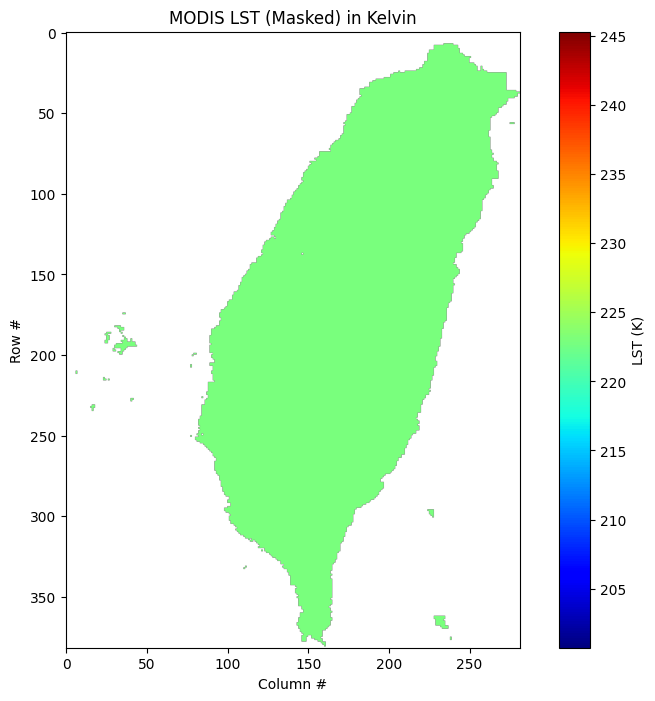

In [38]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/DSR/DSR_2000_Winter_ref.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
ndvi_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(ndvi_masked, cmap=cmap)
plt.colorbar(img, label='LST (K)')
plt.title('MODIS LST (Masked) in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()